# Part 2 - Exploratory Data Analytics

Using the output from Part 1. 

The goal of this workbook is to explore the dataset and find answers to the below:

1. Average number of accidents by month by borough
2. What are the most dangerous hours of the day for pedestrians?
3. Year with most accidents?
4. Visualize data
5. Any other insights we find, data quality

I have also created a Tableau workbook to visualize the data. I use Tableau to plot the geolocation information, which also makes it handy to see if there are DQ issues with the data as-is. An alternative solution would be to download ShapeFiles from NYC OpenData and to plot the latitude and longitude coordinates using the `shapefile` library in python. The link to Tableau Workbook can be found [Tableau Online Dashboard - NYC OpenData](https://public.tableau.com/app/profile/jordan.carson/viz/NYCOpenData/NYCOpenData?publish=yes).

In [70]:
import os
import sys
import pickle
from pathlib import Path
CWD = str(Path.cwd().parent)
sys.path.append(CWD)
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import datatable as dt
from datatable import f, by
from common.utilities import decorators 
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
print(CWD)

/Users/jordancarson/Projects/JPM/data-engineering-nyc


We are going to be using both `pandas` for our EDA (exploratory data analysis). The below data has not been transformed from source and is in the same shape and size as the entire NYC OpenData MVCC table. We have parameters within pd.read_csv that will us to transform while reading.

In [2]:
collision_df = pd.read_csv(
    os.path.join(CWD, '.data', 'output.csv'),
    # parse_dates={'crash_date_time': ["crash_date", "crash_time"]},
    # infer_datetime_format=True,
    dtype={'zip_code': "str"}
)

In [3]:
collision_df.shape

(1830092, 30)

We have 1,830,092 rows, with 29 columns. A [data dictionary](https://data.cityofnewyork.us/api/views/h9gi-nx95/files/bd7ab0b2-d48c-48c4-a0a5-590d31a3e120?download=true&filename=MVCollisionsDataDictionary_20190813_ERD.xlsx) is available which shows the metadata and table relationship between the Motor Vehicle - Crashes, Vehicles and Persons.

In [4]:
collision_table = dt.Frame(collision_df)

In [51]:
collision_df.head(5)

,Unnamed: 0,crash_date,crash_time,borough,zip_code,latitude,longitude,location,on_street_name,off_street_name,...,collision_id,vehicle_type_code1,vehicle_type_code2,contributing_factor_vehicle_3,vehicle_type_code_3,cross_street_name,contributing_factor_vehicle_4,contributing_factor_vehicle_5,vehicle_type_code_4,vehicle_type_code_5
0,0,2012-07-01T00:00:00.000,2021-10-15 10:40:00,MANHATTAN,10013.0,40.720854,-74.003929,"{'latitude': '40.7208537', 'longitude': '-74.0...",CANAL STREET,WOOSTER STREET,...,22,SPORT UTILITY / STATION WAGON,VAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2012-07-01T00:00:00.000,2021-10-15 12:18:00,MANHATTAN,10004.0,40.704799,-74.016685,"{'latitude': '40.7047985', 'longitude': '-74.0...",BATTERY PLACE,WEST STREET,...,23,TAXI,TAXI,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2012-07-01T00:00:00.000,2021-10-15 15:00:00,NaN,NaN,NaN,NaN,NaN,WATER STREET,OLD SLIP,...,24,BUS,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2012-07-01T00:00:00.000,2021-10-15 18:00:00,MANHATTAN,10007.0,40.713692,-74.013754,"{'latitude': '40.7136919', 'longitude': '-74.0...",WEST STREET,VESEY STREET,...,25,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2012-07-01T00:00:00.000,2021-10-15 19:30:00,MANHATTAN,10013.0,40.719058,-74.012442,"{'latitude': '40.719058', 'longitude': '-74.01...",WEST STREET,HARRISON STREET,...,26,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
collision_df['crash_date'].min(), collision_df['crash_date'].max()

(Timestamp('2012-07-01 00:00:00'), Timestamp('2021-10-11 00:00:00'))

The Collision Data **begins** on ***July 1st 2012*** and series **ends** on ***October 11th 2021***. 

## Adding Features

If we want to find the answers to some of Michael's questions we first need to include additional features in our result-set. Creating time specific fields, to pivot by later.

In [52]:
collision_df['crash_date'] = pd.to_datetime(collision_df['crash_date'], format="%Y-%m-%d")
collision_df['crash_time'] = collision_df['crash_time'].str[11:] # slicing to get only the time value back
collision_df['year'] = collision_df['crash_date'].dt.year
collision_df['month'] = collision_df['crash_date'].dt.month
collision_df['day'] = collision_df['crash_date'].dt.day
collision_df['hour'] = collision_df['crash_time'].str[:2]
collision_df['minutes'] = collision_df['crash_time'].str[3:5]
collision_df['seconds'] = collision_df['crash_time'].str[6:]
collision_df['incidents'] = 1

In [6]:
# what columns are available
collision_df.columns

Index(['Unnamed: 0', 'crash_date', 'crash_time', 'borough', 'zip_code',
       'latitude', 'longitude', 'location', 'on_street_name',
       'off_street_name', 'number_of_persons_injured',
       'number_of_persons_killed', 'number_of_pedestrians_injured',
       'number_of_pedestrians_killed', 'number_of_cyclist_injured',
       'number_of_cyclist_killed', 'number_of_motorist_injured',
       'number_of_motorist_killed', 'contributing_factor_vehicle_1',
       'contributing_factor_vehicle_2', 'collision_id', 'vehicle_type_code1',
       'vehicle_type_code2', 'contributing_factor_vehicle_3',
       'vehicle_type_code_3', 'cross_street_name',
       'contributing_factor_vehicle_4', 'contributing_factor_vehicle_5',
       'vehicle_type_code_4', 'vehicle_type_code_5', 'year', 'month', 'day',
       'hour', 'minutes', 'seconds', 'number'],
      dtype='object')

In [7]:
# Next find missing data
print(collision_df.shape[0] - collision_df.count())

Unnamed: 0                             0
crash_date                             0
crash_time                             0
borough                           564983
zip_code                          565203
latitude                          214300
longitude                         214300
location                          214300
on_street_name                    373516
off_street_name                   656307
number_of_persons_injured             18
number_of_persons_killed              31
number_of_pedestrians_injured          0
number_of_pedestrians_killed           0
number_of_cyclist_injured              0
number_of_cyclist_killed               0
number_of_motorist_injured             0
number_of_motorist_killed              0
contributing_factor_vehicle_1       5247
contributing_factor_vehicle_2     264256
collision_id                           0
vehicle_type_code1                  9986
vehicle_type_code2                313450
contributing_factor_vehicle_3    1705024
vehicle_type_cod

Some fields do have many missing value. Date and time is always populated. There are 565,203 cases with no zip_code and 564,983 with no borough. Latitude and Longitude data has about 214,300 missing entries. Along with the location - location is a tuple of the lat/long data. We should be able to infer the zip-code and borough from the geolocation fields and or from additional sources.

From the dataset we can ask the following questions. 

1. Which borough has the most collisions?
2. What is the biggest reason?
3. Is there a particular zip code that has more collisions than others?

In [21]:
# Which borough has the most collisions?
(collision_df
    .groupby('borough')
    .agg({'collision_id': len})
    .sort_values(by='collision_id', ascending=False)
)

,collision_id
borough,
BROOKLYN,398169
QUEENS,338807
MANHATTAN,291402
BRONX,183406
STATEN ISLAND,53325


Most accidents and collisions occur in Brooklyn and Queens. What are the biggest reasons for collisions in Brooklyn and Queens?

In [30]:
# What is the biggest reason for collisions?
(collision_df[collision_df['borough'].isin(['BROOKLYN', 'QUEENS'])]
    .groupby('contributing_factor_vehicle_1')
    .agg({'collision_id': len})
    .sort_values(by='collision_id', ascending=False)
    .head(15)
)

,collision_id
contributing_factor_vehicle_1,
Unspecified,297863
Driver Inattention/Distraction,135604
Failure to Yield Right-of-Way,53638
Backing Unsafely,33358
Following Too Closely,24053
Passing Too Closely,17878
Passing or Lane Usage Improper,16585
Other Vehicular,14369
Turning Improperly,14085


Most of the collisions are unspecified. In fact, this is the largest factor across all boroughs. See below.

In [32]:
# What is the biggest reason for collisions?
(collision_df
    .groupby('contributing_factor_vehicle_1')
    .agg({'collision_id': len})
    .sort_values(by='collision_id', ascending=False)
    .head(5)
)

,collision_id
contributing_factor_vehicle_1,
Unspecified,647943
Driver Inattention/Distraction,354540
Failure to Yield Right-of-Way,105892
Following Too Closely,95262
Backing Unsafely,69258


In [158]:
# Which zipcodes have the largest collisions?
(collision_df
    .groupby('zip_code')
    .agg({'collision_id': len})
    .sort_values(by='collision_id', ascending=False)
    .head(5)
)

,collision_id
zip_code,
11207.0,21026
11236.0,14981
11203.0,14258
11234.0,14100
10019.0,13835


In [157]:

nomi_zipcode_data = nomi.query_postal_code('11207')
nomi_zipcode_data

postal_code          11207
country_code            US
place_name        Brooklyn
state_name        New York
state_code              NY
county_name          Kings
county_code           47.0
community_name         NaN
community_code         NaN
latitude           40.6705
longitude          -73.894
accuracy               4.0
Name: 0, dtype: object

The location with the largest number of collisions, is Kings County in Brooklyn. `pgeocode` provides a very convenient interface to pull information from zip codes. We will talk about this more.

## Question 1: What are the average number of accidents per month per borough

We summarize the collisions per year and divide the amount by 12 to obtain an average per month by borough. In 2012, Staten Island had an average of 408 1/2 accidents per month, while in 2015 Brooklyn had 4,237!

In [113]:
average_per_month_per_bureau = pd.pivot_table(collision_df, index=['borough'], columns=['year'], values=['number'], aggfunc=np.sum).transform(lambda x: x/12)

In [114]:
average_per_month_per_bureau

number                                         \
year                  2012         2013         2014         2015   
borough                                                             
BRONX           792.583333  1647.333333  1640.666667  1771.500000   
BROOKLYN       1942.083333  3918.333333  3979.833333  4237.250000   
MANHATTAN      1726.750000  3465.083333  3438.916667  3543.750000   
QUEENS         1594.833333  3275.750000  3418.416667  3540.750000   
STATEN ISLAND   408.500000   691.250000   551.166667   528.666667   

                                                                   \
year                  2016         2017         2018         2019   
borough                                                             
BRONX          1805.000000  1783.166667  1921.583333  1869.750000   
BROOKLYN       3955.333333  3742.916667  3942.666667  3706.500000   
MANHATTAN      3006.416667  2647.833333  2617.666667  2216.083333   
QUEENS         3449.500000  3218.916667  3439.750000  3322.083333   
STATEN ISLAND   559.083333   520.083333   514.250000   304.166667   

                                         
year                  2020         2021  
borough                                  
BRONX          1191.583333   860.666667  
BROOKLYN       2122.166667  1633.666667  
MANHATTAN       904.333333   716.666667  
QUEENS         1722.000000  1251.916667  
STATEN ISLAND   199.000000   167.583333

## Question 2: Which hour of the day is the most dangerous for pedestrians?

/var/folders/x_/s700z8zn2yb_tphnyd_vqg900000gn/T/ipykernel_15701/3379795862.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pedestrians_injured['hour'] = pedestrians_injured['hour'].astype(int)


[]

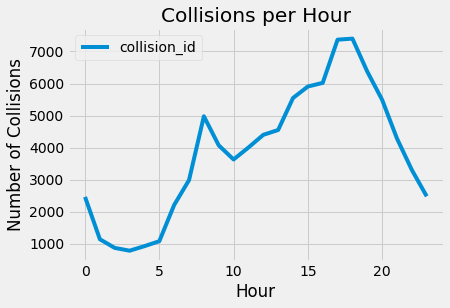

In [74]:
def plot_collisions_by_hour(data):
    pedestrians_injured = data.query("number_of_pedestrians_injured > 0 | number_of_pedestrians_killed > 0")
    pedestrians_injured['hour'] = pedestrians_injured['hour'].astype(int)
    p = pedestrians_injured.groupby('hour').agg({'collision_id': len}).sort_values(by='hour', ascending=False)
    p.plot()
    plt.title('Collisions per Hour')
    plt.xlabel('Hour')
    plt.ylabel('Number of Collisions')
    # sns.barchart(data=p, x='')
    return plt.plot()
plot_collisions_by_hour(collision_df)

From the chart above, the largest number of collisions occur during afternoon peak hours. Specifically during 17 and 18 hours, corresponding to 5:00 PM and 6:00 PM. This makes sense as most people are coming home from work - tired or over-worked. What is the biggest reason for the pedestrian collisions during the hours of 5 and 6 PM?

The few top reasons are due to Driver Inattention.

In [171]:
pedestrians_injured = collision_df.query("(number_of_pedestrians_injured > 0 | number_of_pedestrians_killed > 0)")
pedestrians_injured['hour'] = pedestrians_injured['hour'].astype(int)
pedestrians_injured = pedestrians_injured[(pedestrians_injured['hour'] >= 5) & (pedestrians_injured['hour'] <= 6)]
(pedestrians_injured
    .groupby('contributing_factor_vehicle_1')
    .agg({'collision_id': len})
    .sort_values(by='collision_id', ascending=False)
    .head(5)
)

/var/folders/x_/s700z8zn2yb_tphnyd_vqg900000gn/T/ipykernel_15701/161839053.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pedestrians_injured['hour'] = pedestrians_injured['hour'].astype(int)


,collision_id
contributing_factor_vehicle_1,
Unspecified,1227
Driver Inattention/Distraction,668
Failure to Yield Right-of-Way,641
Pedestrian/Bicyclist/Other Pedestrian Error/Confusion,86
View Obstructed/Limited,73


## Question 3: Which year has the most accidents?

[]

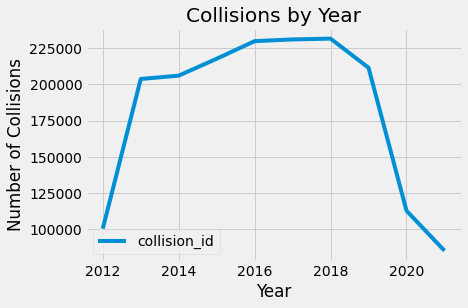

In [75]:
def plot_collisions_by_year(data):
    # pedestrians_injured = data.query("number_of_pedestrians_injured > 0 | number_of_pedestrians_killed > 0")
    data['year'] = data['year'].astype(int)
    p = data.groupby('year').agg({'collision_id': len}).sort_values(by='year', ascending=False)
    p.plot()
    plt.title('Collisions by Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Collisions')
    # sns.barchart(data=p, x='')
    return plt.plot()
plot_collisions_by_year(collision_df)

The year with the most collisions is 2018. 

# Data Quality

Working with this data we know there are some data quality issues. For example, the geolocation information. If you look at the Tableau Dashboard you will notice an issue with how the zip-codes are plotting on the map. The reason why this is occuring is because we typically take the **AVG()** of all data points within the lat and long vectors. If we have a value with 0.0, it will negatively impact the rest of the vector. This is evident with the left graph.

We should replace this latitude and longitude data with NaN / Null, when it is equal to 0.0. We can replace or do this when we pivot / group the data. 

In [17]:
collision_df.loc[:, ['latitude', 'longitude']].describe()

,latitude,longitude
count,1.615792e+06,1.615792e+06
mean,4.067283e+01,-7.383508e+01
std,1.447575e+00,2.823822e+00
min,0.000000e+00,-2.013600e+02
25%,4.066845e+01,-7.397563e+01
50%,4.072168e+01,-7.392805e+01
75%,4.076903e+01,-7.386668e+01
max,4.334444e+01,0.000000e+00


Latitude (0.0) the min - is a data quality issue. This is wrong because the location of (0.0, 0.0) is known as Null Island, this is where the Prime meridian and the equator intersect. 

In [24]:
# Confirm first - Finding the number of issues and a few IDs for 0.0 Latitude
len(collision_df[collision_df['latitude'] == 0.0]['collision_id']), collision_df[collision_df['latitude'] == 0.0]['collision_id'].head()

(2038,
 785785    3421906
 785806    3421927
 813121    3449248
 816864    3452991
 816865    3452992
 Name: collision_id, dtype: int64)

There are about 2,038 records with a latitude of 0.0 - I expect the longitude data to be the same IDs. As we can see below, the location field is a dictionary of lat/long, and when the latitude is 0.0 the longitude is 0.0. This is a data quality issue.

In [30]:
# filtering on a given collision ID to find 
collision_df[collision_df['collision_id'].isin([3452992, 3452991]) ]['location']

816864    {'latitude': '0.0', 'longitude': '0.0'}
816865    {'latitude': '0.0', 'longitude': '0.0'}
Name: location, dtype: object

# Next Steps

This is a very brief introduction into the Motor Vehicle Crash Collision dataset. If we were to extend this project to incorporate more data and to address the data quality, we should inspect the two tables that share a relationship - Vehicles and Persons. 

The next steps would be to clean-up the dataset, by enriching the underlying data with publically available data and other python related libraries. For example, we pulled a list of all the zip_codes and boroughs in manhattan from a website. We used a popular library to parse html called `BeautifulSoup`. Next, would be to create a function to return latitude and longtitude coordinates for all the zip codes that do not have lat/long. We will use the `geopy` library. 

In [150]:
def get_geo_data(country_code='us'):
    from src.api.zip_codes import get_zip_codes
    import pgeocode
    nomi = pgeocode.Nominatim(country_code)
    
    zip_codes = get_zip_codes()
    unique_zips = list(set(zip_codes['zip_code']))

    nomi_zipcode_data = nomi.query_postal_code(unique_zips)
    return nomi_zipcode_data
    
geo_df = get_geo_data()

In [153]:
enriched_data = pd.merge(collision_df, geo_df, left_on='zip_code', right_on='postal_code', how='left')

In [172]:
enriched_data.shape

(1830092, 49)

Our enriched data now contains 1830092 rows and 49 columns!

# Conclusion

We were able to answer Mikes questions using Python and Tableau. I hope this general notebook provides a general introduction into my code style and technical abilities.Also, showcasing the ability to solve similar problems with different technologies. We did not get the chance to showcase `pydatatable`, if you want to look more into the package this doc [compares pandas to datatable](https://datatable.readthedocs.io/en/latest/manual/comparison_with_pandas.html). 

Thank You!

Best,
Jordan Carson